In [1]:
import numpy as np
import pandas
from IPython.display import display, clear_output
pandas.options.mode.chained_assignment = None 

def sigmoid(z):
    return 1/(1 + np.exp(-z))

def norm(w):
    return np.sqrt(w.dot(w))    

def buildRanges(df):
    ranges={}
    getmax_min = lambda c: ranges.update([(c.name, (c.min(), c.max()))])
    df.apply(getmax_min, axis=0)
    return ranges

def scale(c):
    m=ranges[c.name][0]
    M=ranges[c.name][1]
    if (m != M):
        return (c - m)/(M - m)
    else:
        return c - (M - 1)
    

In [2]:
df = pandas.read_csv('data/train.csv');

X=df[['Pclass', 'Sex','Fare', 'Age', 'Parch', 'Embarked', 'SibSp', 'Survived' ]]
X=X.dropna()

Y=X['Survived'].apply(lambda n: 2*n -1)
X=X.drop("Survived", axis=1)

X['Sex']=X['Sex'].map({"male": 0, "female":1})
X['Embarked']=X['Embarked'].map({"C": 0, "S": 1, "Q": 2})
X['Constant']=1

X = X.astype(np.float128)

ranges=buildRanges(X)
X = X.apply(scale, axis=0).to_numpy()

Y=Y.astype(np.int16).to_numpy()
N=X.shape[0]

In [3]:
grad=0
w=np.zeros(np.shape(X)[1])
l_rate=0.15
target=1e-9
max_iter=1000000

def gradient(w):
    e = np.exp(Y*w.dot(X.T))    
    quo=sigmoid(-Y*w.dot(X.T))
    return -np.sum((X.T * Y*quo).T, axis=0)/N


for i in range(max_iter):
    grad=gradient(w)
    w = w - l_rate*grad;
    if norm(grad) < target:
        break    
   
print(f"{norm(grad)}: [{', '.join([str(wi) for wi in w])}]")
    


9.999364578573172e-10: [-2.3989339066601509975, 2.6377050590445067528, 0.72852223877526342625, -3.4490919691954006802, -0.3605629752051774381, -0.81119166392875849376, -1.8141899742752406293, 1.7848137494856450103]


Erro minimo em 0.5957
81.882% de acerto
31.882% sobreviveriam de acordo com o modelo.
40.449% realmente sobreviveram.


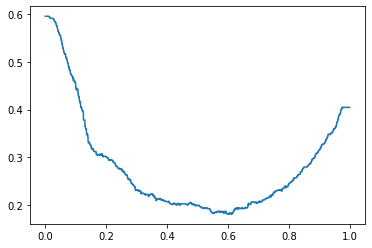

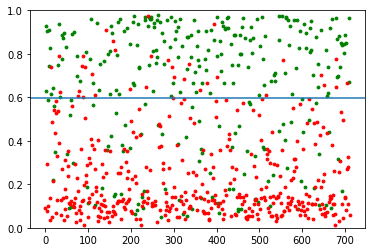

In [4]:
import matplotlib.pyplot as plt


p = sigmoid(w.dot(X.T))
ind=np.arange(len(p))

p_pos=p[Y == 1]
p_neg=p[Y==-1]

ind_pos=ind[Y== 1]
ind_neg=ind[Y== -1]

lim=np.arange(0,1, 0.0001)

calc_error = np.vectorize(lambda l: (len(p_neg[p_neg > l]) + len(p_pos[p_pos < l]))/len(p))
error=calc_error(lim)

fig, ax =plt.subplots()
ax.plot(lim, error)

min_lim=lim[np.argmin(error)]
print(f"Erro minimo em {str(min_lim)}")

fig, ax = plt.subplots()
ax.set_ylim(0,1)

ax.scatter(ind_pos, p_pos, color='green', s=8)
ax.scatter(ind_neg, p_neg, color='red', s=8)
ax.axhline(min_lim)

error = (len(p_neg[p_neg > min_lim]) + len(p_pos[p_pos < min_lim]))/len(p)

print(f"{(1-error)*100:.3f}% de acerto")
print(f"{(len(p[p > min_lim])/len(p))*100:.3f}% sobreviveriam de acordo com o modelo.")
print(f"{(len(Y[Y==1])/len(Y))*100:.3f}% realmente sobreviveram.")

In [5]:
# w=np.array([-2.3989339066601509975, 2.6377050590445067528, 0.72852223877526342625, -3.4490919691954006802, -0.3605629752051774381, -0.81119166392875849376, -1.8141899742752406293, 1.7848137494856450103])
# ranges={'Pclass': (1.0, 3.0),
#  'Sex': (0.0, 1.0),
#  'Fare': (0.0, 512.32920000000001437),
#  'Age': (0.41999999999999998446, 80.0),
#  'Parch': (0.0, 6.0),
#  'Embarked': (0.0, 2.0),
#  'Constant': (1.0, 1.0),
#  'SibSp': (0.0, 5.0)}

In [6]:
res=[]

df=pandas.read_csv("data/test.csv")
X=df[['Pclass', 'Sex','Fare', 'Age', 'Parch', 'Embarked', 'SibSp', 'PassengerId']]

X[X.isna().any(axis=1)].apply(lambda r: res.append({'PassengerId': r['PassengerId'], 'Survived': 0}), axis=1)
X=X.dropna()

ids=X['PassengerId'].astype(np.int64).to_numpy()
X=X.drop('PassengerId', axis=1)

X['Sex']=X['Sex'].map({"male": 0, "female":1})
X['Embarked']=X['Embarked'].map({"C": 0, "S": 1, "Q": 2})
X['Constant']=1

X = X.astype(np.float128)
X = X.apply(scale, axis=0).to_numpy()

p=sigmoid(w.dot(X.T))

for i in range(len(p)):
    res.append({'PassengerId': ids[i], 'Survived': 1 if p[i] >= 0.5957 else 0})

df_res = pandas.DataFrame(res)
df_res = df_res.sort_values("PassengerId")
df_res.to_csv('data/res.csv', index=False)

df_res

,PassengerId,Survived
87,892,0
88,893,0
89,894,0
90,895,0
91,896,0
...,...,...
84,1305,0
416,1306,1
417,1307,0
85,1308,0
